In [6]:
import re
import json
from datetime import datetime

import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering

import hnswlib



# 1) Очистка текста

def _strip_markdown_links(s: str) -> str:
    # [text](url) -> text
    return re.sub(r"\[([^\]]+)\]\((https?://[^)]+)\)", r"\1", s)

def _normalize_ws(s: str) -> str:
    s = s.replace("\u00a0", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _is_time_line(line: str) -> bool:
    return bool(re.fullmatch(r"\d{1,2}:\d{2}", line))

def _is_small_digit_line(line: str) -> bool:
    return line.isdigit() and len(line) <= 2

def _should_drop_line(line: str) -> bool:
    if not line:
        return True

    line2 = _PUA_RE.sub("", line).strip()
    if not line2:
        return True

    # разделители
    if set(line2) <= set("-–—_"):
        return True

    # методанные
    if line2.startswith("📢 From:") or line2.startswith("📁 Category:") or line2.startswith("🔗 Link:") or line2.startswith("⏰ Time:"):
        return True

    # маркеры медиа
    if line2.startswith("[📷") or line2.startswith("[🎬"):
        return True

    # служебные
    if line2 == "Telegram":
        return True
    if "VIEW MESSAGE" in line2 or "VIEW CHANNEL" in line2 or "INSTANT VIEW" in line2:
        return True

    # мусор
    if _is_time_line(line2) or _is_small_digit_line(line2):
        return True

    # URL
    if re.fullmatch(r"https?://\S+", line2):
        return True

    # реклама
    if "РЕКЛАМА" in line2:
        return True
    if line2.startswith("Подписаться") or "Подписаться" in line2:
        return True
    if "Прислать новости" in line2 or "Новости сюда" in line2:
        return True
    if "knd.gov.ru/license" in line2:
        return True

    # контактные строки
    if "@" in line2 and any(w in line2.lower() for w in ["bot", "реклама", "admin", "pr", "подбор"]):
        return True

    return False

def extract_semantic_text(text: str) -> str:
    if not isinstance(text, str):
        return ""

    text = _strip_markdown_links(text)

    lines = [ln.strip() for ln in text.splitlines()]
    kept = []
    skip_after_telegram = 0

    for ln in lines:
        if not ln:
            continue

        # после строки "Telegram" обычно идёт строка с названием канала - убираем
        if skip_after_telegram > 0:
            skip_after_telegram -= 1
            continue

        ln2 = _PUA_RE.sub("", ln).strip()

        if ln2 == "Telegram":
            skip_after_telegram = 1
            continue

        if _should_drop_line(ln2):
            continue

        # URLs внутри строки
        ln2 = re.sub(r"http\S+|www\.\S+", " ", ln2).strip()

        # очистка markdown
        ln2 = ln2.replace("**", "").replace("__", "")
        ln2 = _normalize_ws(ln2)

        if ln2:
            kept.append(ln2)

    return "\n".join(kept).strip()

def make_title_from_semantic(semantic_text: str, max_len: int = 180) -> str:
    lines = [_normalize_ws(x) for x in semantic_text.splitlines() if _normalize_ws(x)]
    if not lines:
        return ""
    return lines[0][:max_len]

def is_digest_text(semantic_text: str) -> bool:
    return bool(re.search(r"(главные новости|к этому часу|сводка|дайджест|главное за день)", semantic_text, flags=re.IGNORECASE))


# 2) Форматируем дату

def _infer_base_date_from_texts(df: pd.DataFrame) -> datetime:
    ts = []
    for t in df["text"].fillna("").tolist():
        m = _SCRAPE_TS_RE.search(t)
        if m:
            dt = pd.to_datetime(f"{m.group(1)} {m.group(2)}", errors="coerce")
            if pd.notna(dt):
                ts.append(dt.to_pydatetime())
    return max(ts) if ts else datetime.now()

def parse_telegram_date(raw: str, base_date: datetime) -> pd.Timestamp:
    """
    месяц/год берём из base_date. Если получилась дата “в будущем”, сдвигаем на месяц назад.
    """
    if not isinstance(raw, str) or not raw.strip():
        return pd.NaT

    try:
        cleaned = _PUA_RE.sub(" ", raw)
        cleaned = re.sub(r"[^\d:\s]", " ", cleaned)
        cleaned = _normalize_ws(cleaned)

        day = None
        hm = None
        for part in cleaned.split():
            if part.isdigit() and len(part) <= 2:
                day = int(part)
            elif re.fullmatch(r"\d{1,2}:\d{2}", part):
                hm = part

        if day is None or hm is None:
            return pd.NaT

        y, m = base_date.year, base_date.month
        candidate = pd.to_datetime(f"{y:04d}-{m:02d}-{day:02d} {hm}", format="%Y-%m-%d %H:%M", errors="coerce")
        if pd.isna(candidate):
            return pd.NaT

        if candidate.to_pydatetime() > base_date:
            prev = (pd.Timestamp(y, m, 1) - pd.Timedelta(days=1))
            candidate = pd.to_datetime(f"{prev.year:04d}-{prev.month:02d}-{day:02d} {hm}", errors="coerce")

        return candidate
    except Exception:
        return pd.NaT



# 3) Подготовка dataframe

def preprocess_data(df: pd.DataFrame, min_semantic_chars: int = 40) -> pd.DataFrame:
    df = df.copy()

    # даты
    base_date = _infer_base_date_from_texts(df)
    df["published_at"] = df["published_at"].apply(lambda x: parse_telegram_date(x, base_date))

    # текст
    df["semantic_text"] = df["text"].apply(extract_semantic_text)
    df["title"] = df["semantic_text"].apply(make_title_from_semantic)

    # флаги
    df["is_digest"] = df["semantic_text"].apply(is_digest_text)
    df["is_short"] = df["semantic_text"].fillna("").str.len() < min_semantic_chars

    # убираем новости без смыслового наполнения с доп алертом
    before = len(df)
    df = df[df["semantic_text"].fillna("").str.len() > 0].copy()
    after = len(df)
    if after < before:
        print(f"Внимание: удалено {before-after} записей без смыслового текста (служебные/пустые).")

    df.dropna(subset=["published_at"], inplace=True)

    df["full_text"] = df["semantic_text"]
    return df



# 4) Эмбеддинги

def embed_texts(texts: list[str], model: SentenceTransformer, batch_size: int = 32) -> np.ndarray:
    emb = model.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True
    )
    return emb.astype(np.float32)



# 5) Кластеризация (1-й проход)

def _fit_agglom_cosine(embeddings: np.ndarray, distance_threshold: float, linkage: str = "complete") -> np.ndarray:
    try:
        model = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=distance_threshold,
            linkage=linkage,
            metric="cosine",
        )
    except TypeError:
        model = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=distance_threshold,
            linkage=linkage,
            affinity="cosine",
        )
    return model.fit_predict(embeddings)

def cluster_first_pass(
    df: pd.DataFrame,
    embeddings_all: np.ndarray,
    dist_thr_main: float = 0.16,
) -> pd.DataFrame:
    """
    1-й проход: кластеризуем ТОЛЬКО событийные новости.
    Digest-новости назначаем отдельные cluster_id позже.
    Эмбеддинги считаем 1 раз для всех, сюда передаем embeddings_all.
    """
    df = df.copy()
    df["cluster_id"] = -1

    # «истинные» новости
    mask_main = (~df["is_short"]) & (~df["is_digest"])
    if mask_main.any():
        emb_main = embeddings_all[mask_main.to_numpy()]
        labels_main = _fit_agglom_cosine(
            emb_main,
            distance_threshold=dist_thr_main,
            linkage="complete"
        )
        df.loc[mask_main, "cluster_id"] = labels_main

    # все остальные (digest и short) пока оставляем -1
    df["cluster_id"] = df["cluster_id"].astype(int)
    return df

def assign_non_event_clusters(df: pd.DataFrame) -> pd.DataFrame:
    """
    Digest и short новости не считаем "событиями".
    short: каждая запись отдельный кластер
    digest: группируем по (нормализованный заголовок, округление времени до часа)
    чтобы одинаковые "Главное за день" не дробились.
    """
    df = df.copy()

    # стартовый offset для новых кластеров
    offset = int(df["cluster_id"].max()) + 1 if (df["cluster_id"].max() >= 0) else 0

    # short: уникальные
    mask_s = df["is_short"]
    if mask_s.any():
        n = int(mask_s.sum())
        df.loc[mask_s, "cluster_id"] = np.arange(offset, offset + n)
        offset += n

    # digest: правило по заголовку + время публикации
    mask_d = df["is_digest"] & (~df["is_short"])
    if mask_d.any():
        def norm_title(t: str) -> str:
            t = (t or "").lower()
            t = re.sub(r"\s+", " ", t).strip()

            t = t.replace("главные новости к этому часу", "главные новости к этому часу")
            t = t.replace("главное за день", "главное за день")
            return t[:80]

        tmp = df.loc[mask_d, ["title", "published_at"]].copy()
        tmp["digest_key"] = tmp["title"].astype(str).apply(norm_title)
        tmp["hour_bucket"] = pd.to_datetime(tmp["published_at"]).dt.floor("H")


        keys = tmp["digest_key"].astype(str) + "||" + tmp["hour_bucket"].astype(str)
        codes, _ = pd.factorize(keys, sort=True)

        df.loc[mask_d, "cluster_id"] = codes + offset
        offset = int(df["cluster_id"].max()) + 1

    df["cluster_id"] = df["cluster_id"].astype(int)
    return df


# 6) Выбор канонической новости и summary

def select_canonical_and_summary(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    df = df.copy()
    df = df.sort_values(["cluster_id", "published_at"], ascending=[True, True])

    df["is_canonical"] = False
    canon_idx = df.groupby("cluster_id", as_index=False).head(1).index
    df.loc[canon_idx, "is_canonical"] = True

    sizes = df.groupby("cluster_id")["id"].size()
    news_ids = df.groupby("cluster_id")["id"].apply(list)

    canon = df[df["is_canonical"]].set_index("cluster_id")
    summary = pd.DataFrame({
        "cluster_id": sizes.index,
        "size": sizes.values,
        "canonical_news_id": canon["id"],
        "canonical_title": canon["title"].fillna("").astype(str).str.slice(0, 220),
        "news_ids": news_ids.values
    }).reset_index(drop=True)

    return df, summary



# 7) Второй проход мёрджа (на уровне кластеров)

def merge_clusters_second_pass_centroid(
    df: pd.DataFrame,
    embeddings_all: np.ndarray,
    sim_threshold: float = 0.91,
    top_k: int = 10,
    time_window_hours: int = 96,
) -> pd.DataFrame:
    """
    2-й проход: сливаем кластера по среднему эмбеддингов кластера.
    Эмбеддинги не пересчитываем – берём embeddings_all.
    Сливаем только событийные кластера.
    """
    df = df.copy()

    event_mask = (~df["is_digest"]) & (~df["is_short"])
    if event_mask.sum() <= 1:
        return df

    df_event = df[event_mask].copy()
    emb_event = embeddings_all[event_mask.to_numpy()]

    cluster_ids = df_event["cluster_id"].to_numpy()
    uniq = np.unique(cluster_ids)

    if len(uniq) <= 1:
        return df

    centroids = []
    times = []
    uniq_list = []

    for cid in uniq:
        idx = np.where(cluster_ids == cid)[0]
        c = emb_event[idx].mean(axis=0)
        c = c / (np.linalg.norm(c) + 1e-12)
        centroids.append(c.astype(np.float32))
        uniq_list.append(int(cid))

        t = df_event.loc[df_event["cluster_id"] == cid, "published_at"].min()
        times.append(pd.to_datetime(t))

    centroids = np.vstack(centroids).astype(np.float32)
    times = np.array(times, dtype="datetime64[ns]")

    K, D = centroids.shape
    index = hnswlib.Index(space="cosine", dim=D)
    index.init_index(max_elements=K, ef_construction=200, M=32)
    index.add_items(centroids, np.arange(K))
    index.set_ef(80)

    nbrs, dists = index.knn_query(centroids, k=min(top_k, K))
    sims = 1.0 - dists
    window = np.timedelta64(time_window_hours, "h")

    # слияние через DSU
    class DSU:
        def __init__(self, n):
            self.p = list(range(n))
            self.r = [0]*n
        def find(self, x):
            while self.p[x] != x:
                self.p[x] = self.p[self.p[x]]
                x = self.p[x]
            return x
        def union(self, a, b):
            ra, rb = self.find(a), self.find(b)
            if ra == rb:
                return
            if self.r[ra] < self.r[rb]:
                self.p[ra] = rb
            elif self.r[ra] > self.r[rb]:
                self.p[rb] = ra
            else:
                self.p[rb] = ra
                self.r[ra] += 1

    dsu = DSU(K)

    for i in range(K):
        for j, sim in zip(nbrs[i], sims[i]):
            j = int(j)
            if j == i:
                continue
            if sim < sim_threshold:
                continue
            if np.abs(times[i] - times[j]) > window:
                continue
            dsu.union(i, j)

    roots = [dsu.find(i) for i in range(K)]
    root2new = {}
    old2new = {}
    new_id = 0
    for i, r in enumerate(roots):
        if r not in root2new:
            root2new[r] = new_id
            new_id += 1
        old2new[uniq_list[i]] = root2new[r]

    df.loc[event_mask, "cluster_id"] = df.loc[event_mask, "cluster_id"].map(old2new).astype(int)

    return df

def reindex_cluster_ids(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    uniq = np.sort(df["cluster_id"].unique())
    mapping = {old: new for new, old in enumerate(uniq)}
    df["cluster_id"] = df["cluster_id"].map(mapping).astype(int)
    return df



# 8) Пайплайн

def run_pipeline(
    input_path: str,
    model_name: str = "ai-forever/sbert_large_nlu_ru",
    batch_size: int = 32,
    min_semantic_chars: int = 40,
    dist_thr_main: float = 0.16,
    merge_sim_threshold: float = 0.92,
    merge_time_window_hours: int = 96,
    merge_top_k: int = 25,
):
    # load
    df_raw = pd.read_json(input_path)
    required = {"id", "text", "source", "published_at"}
    missing = required - set(df_raw.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")


    df = preprocess_data(df_raw, min_semantic_chars=min_semantic_chars)
    print(f"Общее количество новостей после очистки: {len(df)}")


    model = SentenceTransformer(model_name)

    embeddings_all = embed_texts(df["full_text"].tolist(), model, batch_size=batch_size)


    df = cluster_first_pass(
        df,
        embeddings_all=embeddings_all,
        dist_thr_main=dist_thr_main,
    )

    df = assign_non_event_clusters(df)

    df = merge_clusters_second_pass_centroid(
        df,
        embeddings_all=embeddings_all,
        sim_threshold=merge_sim_threshold,
        top_k=merge_top_k,
        time_window_hours=merge_time_window_hours,
    )

    df = reindex_cluster_ids(df)

    final_df, clusters_summary_df = select_canonical_and_summary(df)
    return final_df, clusters_summary_df



# 9) Запуск пайплайна с выводом и сохранением

INPUT_PATH = "tg_messages (116).json" # tg_messages (116).json - 116 записей // news.json - 2000 записей

final_df, clusters_summary_df = run_pipeline(
    input_path=INPUT_PATH,
    model_name="ai-forever/sbert_large_nlu_ru",
    batch_size=32,
    min_semantic_chars=40,
    dist_thr_main=0.16,
    merge_sim_threshold=0.92,
    merge_time_window_hours=96,
    merge_top_k=25,
)

print("\nНайдено кластеров (итог):", final_df["cluster_id"].nunique())

print("\n--- Сводка по кластерам ---")
print(
    clusters_summary_df[["cluster_id", "size", "canonical_title"]]
      .sort_values("size", ascending=False)
)

print("\n--- Финальный результат (фрагмент) ---")
result_columns = ["id", "title", "source", "published_at", "cluster_id", "is_canonical"]
print(final_df[result_columns].sort_values("cluster_id").head(60))

final_df.to_csv("news_dedup_full.csv", index=False, encoding="utf-8")

clusters_summary_df.to_csv("clusters_summary.csv", index=False, encoding="utf-8")

clusters_list = (
    clusters_summary_df[["cluster_id", "news_ids"]]
      .rename(columns={"cluster_id": "group_id"})
      .to_dict("records")
)
with open("clusters_list.json", "w", encoding="utf-8") as f:
    json.dump(clusters_list, f, ensure_ascii=False, indent=2)

print("\nSaved files: news_dedup_full.csv, news_dedup_full.jsonl, clusters_summary.csv, clusters_summary.jsonl, clusters_list.json")


Внимание: удалено 7 записей без смыслового текста (служебные/пустые).
Общее количество новостей после очистки: 108


Batches:   0%|          | 0/4 [00:00<?, ?it/s]


Найдено кластеров (итог): 29

--- Сводка по кластерам ---
    cluster_id  size                                    canonical_title
20          20    15  Прерванный полет: Как движется уголовное дело ...
1            1     6  Спецоперация. Обстановка и главные события на ...
0            0     6  Смотрим фрагмент из «Майора Грома: Игра против...
14          14     6  Large bitcoin holders buy the most coins since...
2            2     4  В бразильском муниципалитете Майн-ду-Риу полиц...
6            6     4  Опытый криптан, купивший биткоин в 2013 году, ...
7            7     4  Боец UFC Чимаев опубликовал пост с фото Адама ...
8            8     4  💉 Французский анестезиолог девять лет убивал п...
11          11     4  Слониха спасла детёныша во время потопа в парк...
15          15     4    🧹 Теперь знаем, где в Москве самый чистый район
17          17     4  Пентагон распорядился подготовить около 1500 в...
3            3     4  Власти Украины запретили проносить в школы опа...
4    

/tmp/ipython-input-3003393078.py:328: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tmp["hour_bucket"] = pd.to_datetime(tmp["published_at"]).dt.floor("H")


In [7]:
# Проверка согласованности кластеров
assert (final_df.groupby("cluster_id")["is_canonical"].sum() == 1).all()

# summary согласован с final_df
canon_map = final_df.loc[final_df["is_canonical"], ["cluster_id", "id"]].set_index("cluster_id")["id"].to_dict()
sum_map = clusters_summary_df.set_index("cluster_id")["canonical_news_id"].to_dict()
bad = [(cid, canon_map.get(cid), sum_map.get(cid)) for cid in sum_map.keys() if canon_map.get(cid) != sum_map.get(cid)]
print("Canonical mismatches:", bad[:10])


Canonical mismatches: []


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


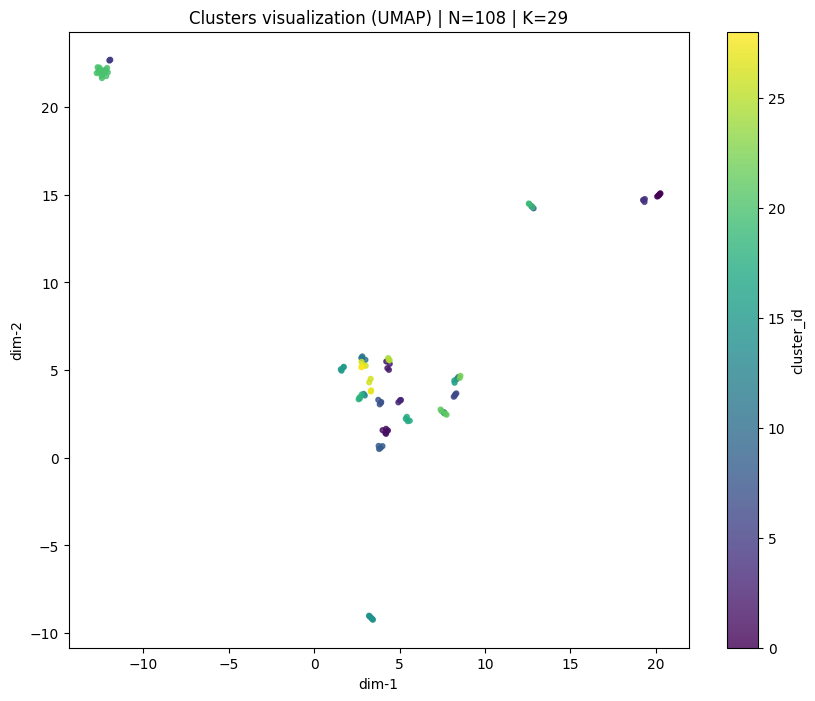

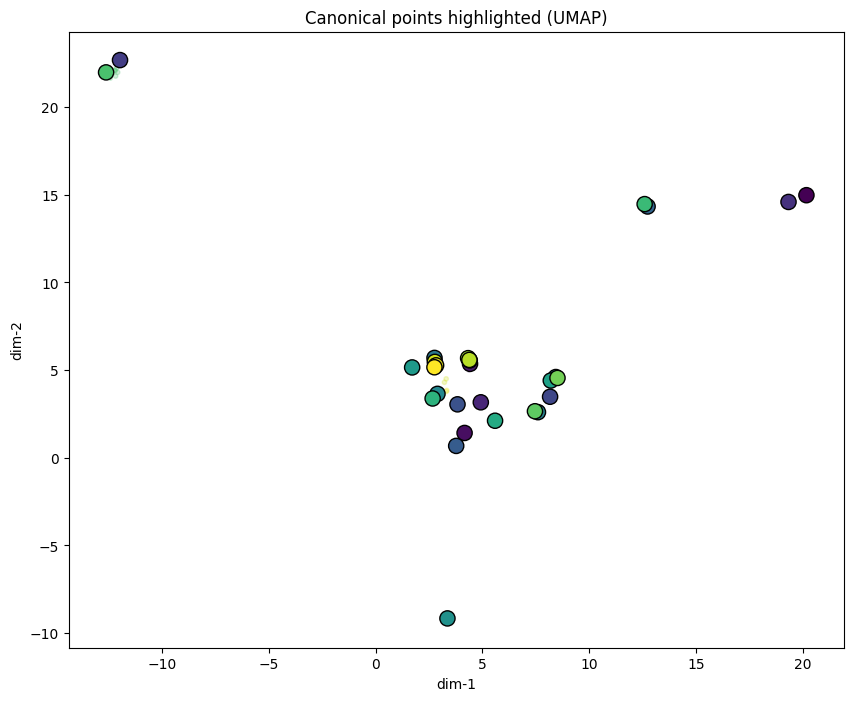

In [8]:
# Визуализация кластеров
try:
    emb_vis = embeddings_all
except NameError:
    try:
        emb_vis = embeddings
    except NameError:
        from sentence_transformers import SentenceTransformer
        model = SentenceTransformer("ai-forever/sbert_large_nlu_ru")
        texts = final_df["semantic_text"].tolist() if "semantic_text" in final_df.columns else final_df["text"].astype(str).tolist()
        emb_vis = model.encode(texts, batch_size=32, show_progress_bar=True, convert_to_numpy=True)


import matplotlib.pyplot as plt

X = np.asarray(emb_vis)

try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
    X2 = reducer.fit_transform(X)
    method = "UMAP"
except Exception:
    from sklearn.decomposition import PCA
    X2 = PCA(n_components=2, random_state=42).fit_transform(X)
    method = "PCA(2D)"


plt.figure(figsize=(10, 8))
plt.scatter(X2[:, 0], X2[:, 1], s=12, c=final_df["cluster_id"].astype(int), alpha=0.8)
plt.title(f"Clusters visualization ({method}) | N={len(final_df)} | K={final_df['cluster_id'].nunique()}")
plt.xlabel("dim-1")
plt.ylabel("dim-2")
plt.colorbar(label="cluster_id")
plt.show()


canon_mask = final_df["is_canonical"].astype(bool).values
plt.figure(figsize=(10, 8))
plt.scatter(X2[:, 0], X2[:, 1], s=10, c=final_df["cluster_id"].astype(int), alpha=0.25)
plt.scatter(X2[canon_mask, 0], X2[canon_mask, 1], s=120, edgecolors="black", linewidths=1.0,
            c=final_df.loc[canon_mask, "cluster_id"].astype(int))
plt.title(f"Canonical points highlighted ({method})")
plt.xlabel("dim-1")
plt.ylabel("dim-2")
plt.show()
